In [39]:

import sys
print(sys.version)
sys.path.append('../')

3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]


In [62]:

import matplotlib.pyplot as plt
from PIL import Image
import os
import sys
import importlib
from plantcv import plantcv as pcv
import cv2
import re
import glob, os


In [63]:
GRAY=0
GAUSS=0
ROI=0
AB=0

pcv.params.debug = None

In [64]:
def extract_parent_path_and_number(img_path):
    # Extract parent path
    parent_path = os.path.dirname(img_path)
    
    # Define the regular expression pattern
    pattern = r'image \((\d+)\)\.JPG'
    
    # Use re.search to find the match in the image path
    match = re.search(pattern, os.path.basename(img_path))
    
    # If a match is found, return the parent path and the extracted number as an integer, else return None
    return parent_path, str(match.group(1)) if match else None

In [65]:
 
file_path = "../dataset/Apple/Apple_Black_rot/ff.jpg"
print(os.path.normpath(file_path))
# Get the parent directory of the file
parent_directory = os.path.dirname(file_path)

# Get the name of the parent folder
parent_folder_name = os.path.basename(parent_directory)
file_name = os.path.basename(file_path).replace(".JPG", "")

print("Parent Folder Name:", parent_folder_name)
print("File Name:", file_name)


../dataset/Apple/Apple_Black_rot/ff.jpg
Parent Folder Name: Apple_Black_rot
File Name: ff.jpg


In [66]:
def load_original(img_path):
    img, path, img_filename  = pcv.readimage(img_path)
    # img, _, _ = pcv.readimage(filename="./leaf.png")
    img, path, img_filename  = pcv.readimage(img_path)
    parent_path, IMGNAME = extract_parent_path_and_number(img_path)
    print(parent_path, IMGNAME)
    IMGNAME = img_filename.replace(".JPG", "")
    # Convert RGB to grayscale
    GRAY = pcv.rgb2gray(rgb_img=img)
    
    # # Plot the original and grayscale images side by side
    # fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    # axes[0].imshow(img)
    # axes[0].set_title('Original Image')
    # axes[0].axis('off')
    
    # axes[1].imshow(GRAY, cmap='gray')
    # axes[1].set_title('Grayscale Image')
    # axes[1].axis('off')
    
    # plt.show()
    pcv.print_image(
            img,
            filename=f"./tmp/{IMGNAME}_original.JPG",
    )
    return img, GRAY, IMGNAME

img,GRAY,IMGNAME= load_original("./hhleaf.JPG")

. None


In [67]:
def guassian_blur(_img,_imgname, _dest):
    s = pcv.rgb2gray_hsv(rgb_img=_img, channel="s")
 
    s_thresh = pcv.threshold.binary(
        gray_img=s, 
        threshold=60, 
        max_value=255, 
        object_type="light"
    )
    _GAUSS = pcv.gaussian_blur(
        img=s_thresh, 
        ksize=(5, 5), 
        sigma_x=0, 
        sigma_y=None
    )
    pcv.print_image(
            _GAUSS,
            filename=f"{_dest}/{_imgname}_gaussian_blur.JPG",
    )
    return _GAUSS

GAUSS = guassian_blur(img, IMGNAME,  "./tmp")

In [94]:
def mask(_img, _imgname, _gauss, _dest):
    # Convert the 'b' channel of the LAB color space from the RGB image to grayscale
    b = pcv.rgb2gray_lab(rgb_img=_img, channel="b")
    
    # Create a binary threshold image from the 'b' channel
    b_thresh = pcv.threshold.binary(
        gray_img=b, threshold=200, max_value=255, object_type="light"
    )

    # Logical OR operation on two binary images
    bs = pcv.logical_or(bin_img1=_gauss, bin_img2=b_thresh)

    # Apply the binary mask to the original image
    masked = pcv.apply_mask(img=_img, mask=bs, mask_color="white")

    # Convert the 'a' and 'b' channels of the LAB color space from the masked image to grayscale
    masked_a = pcv.rgb2gray_lab(rgb_img=masked, channel="a")
    masked_b = pcv.rgb2gray_lab(rgb_img=masked, channel="b")
    
    # Create binary threshold images for the 'a' channel of the masked image
    maskeda_thresh = pcv.threshold.binary(
        gray_img=masked_a, threshold=115, max_value=255, object_type="dark"
    )
    maskeda_thresh1 = pcv.threshold.binary(
        gray_img=masked_a, threshold=135, max_value=255, object_type="light"
    )
    
    # Create a binary threshold image for the 'b' channel of the masked image
    maskedb_thresh = pcv.threshold.binary(
        gray_img=masked_b, threshold=128, max_value=255, object_type="light"
    )
    
    # Logical OR operations on binary images to create composite masks
    ab1 = pcv.logical_or(bin_img1=maskeda_thresh, bin_img2=maskedb_thresh)
    ab = pcv.logical_or(bin_img1=maskeda_thresh1, bin_img2=ab1)
    
    # Fill holes in the 'ab' composite mask
    _AB = pcv.fill(bin_img=ab, size=200)
    
    # Apply the filled 'ab' mask to the original masked image
    _masked2 = pcv.apply_mask(img=masked, mask=_AB, mask_color="white")

    pcv.print_image(
            _masked2,
            filename=f"{_dest}/{IMGNAME}_mask.JPG",
    )

    return _masked2, _AB

masked2, AB = mask(img, IMGNAME, GAUSS, "./tmp")

In [81]:
def roi_objects(_img, _imgname, _AB, _dest):
    pcv.params.debug = "print"
    pcv.params.debug_outdir = _dest
    
    id_objects, obj_hierarchy = pcv.find_objects(img=_img, mask=_AB)
    # print(id_objects)
    roi1, roi_hierarchy = pcv.roi.rectangle(img=_img, x=0, y=0, h=250,w=250)

    _roi_objects, hierarchy3, kept_mask, obj_area = pcv.roi_objects(
        img=_img,
        roi_contour=roi1,
        roi_hierarchy=roi_hierarchy,
        object_contour=id_objects,
        obj_hierarchy=obj_hierarchy,
        roi_type="partial",
    )
  
    # plt.imshow(roi_hierarchy)
    file_rename = (
        _dest
        + "/"
        + str(pcv.params.device - 2)
        + "_obj_on_img.png"
    )
 
    os.rename(file_rename, f"./tmp/{_imgname}_roi_mask.JPG")
 
    for f in glob.glob(f"{_dest}/*.png"):
        os.remove(f)

    pcv.params.debug = None
    return _roi_objects, hierarchy3, kept_mask
    
ROI, HIERARCHY, KEPT_MASK =  roi_objects(img, IMGNAME, AB, "./tmp")

In [48]:
def analysis_obj(_img, _imgname, _roi, _hierarchy, _dest):
 
    pcv.params.debug = "print"
    
    obj, mask = pcv.object_composition(
        img=_img, contours=_roi, hierarchy=_hierarchy
    )
    
    analysis_image = pcv.analyze_object(
        img=_img, obj=obj, mask=mask, label="default"
    )
    
    pcv.print_image(
            analysis_image,
            filename=f"{_dest}/{_imgname}_analysis_obj.JPG",
    )
    
    pcv.params.debug = None

    return mask, obj

MASK , OBJ = analysis_obj(img, IMGNAME, ROI, HIERARCHY, "./tmp")

In [49]:
def pseudolandmarks(_img,_imgname,  _mask, _obj, _dest):
    pcv.params.debug = "print"

    top_x, bottom_x, center_v_x = pcv.x_axis_pseudolandmarks(
        img=_img, obj=_obj, mask=_mask, label="default"
    )
    
    pcv.params.debug = None
    file_rename = (
        _dest
        + "/"
        + str(pcv.params.device - 1)
        + "_x_axis_pseudolandmarks.png"
    )

    os.rename(file_rename, f"{_dest}/{_imgname}_pseudolandmarks.JPG")
    for f in glob.glob("./tmp/*.png"):
        os.remove(f)

    return 

pseudolandmarks(img, IMGNAME, MASK, OBJ, "./tmp")


In [50]:
images = {}
img_new_folder = "./tmp/" 
images = {
    'Fig1. Original': Image.open(img_new_folder+IMGNAME + "_original.JPG"),
    'Fig2. Gaussian_Blur': Image.open(img_new_folder+IMGNAME + "_gaussian_blur.JPG"),
    'Fig3. Mask': Image.open(img_new_folder+IMGNAME + "_mask.JPG"),
    'Fig4. Roi_Objects': Image.open(img_new_folder+IMGNAME + "_roi_mask.JPG"),
    'Fig5. Pseudo-LandMarks': Image.open(img_new_folder+IMGNAME + "_pseudolandmarks.JPG"),
    'Fig6. Analysis Obj.': Image.open(img_new_folder+IMGNAME + "_analysis_obj.JPG")
}

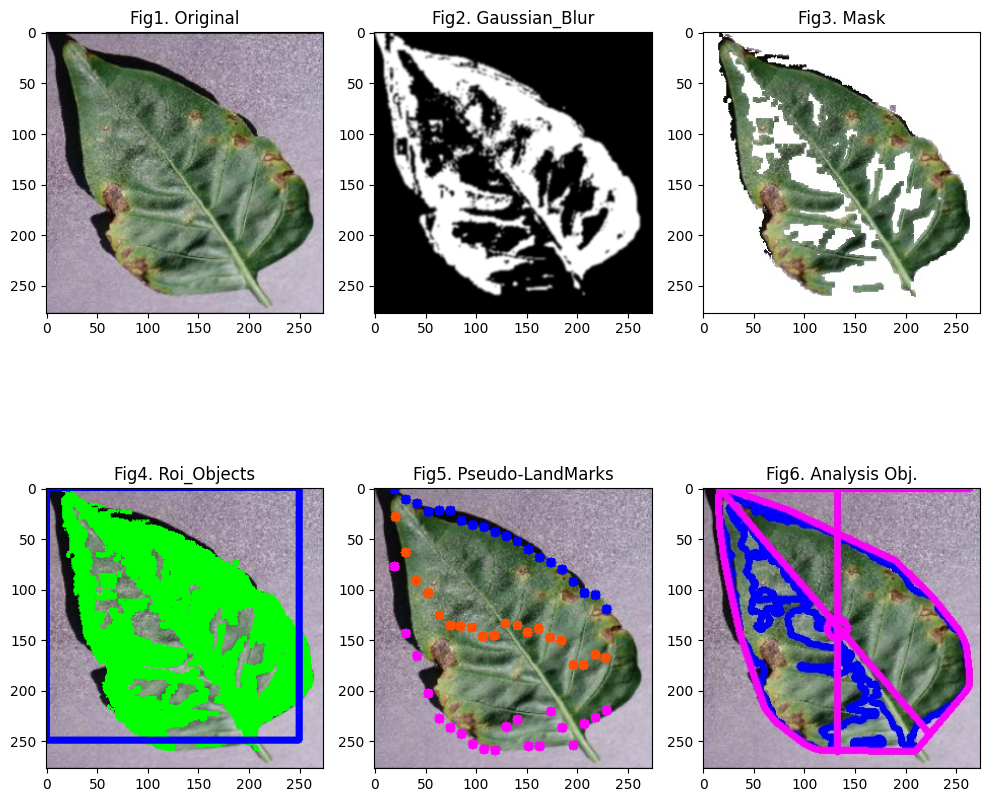

In [51]:
 
# Variable for the number of images per row
images_per_row = 3

# Calculate the number of rows needed based on the number of images and images per row
num_rows = len(images) // images_per_row + len(images) % images_per_row

# Create a multi-row figure with the specified number of images per row
fig, axes = plt.subplots(num_rows, images_per_row, figsize=(10, 5 * num_rows))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Iterate through the images and plot them in the figure
for idx, (img_name, img_data) in enumerate(images.items()):
    row = idx // images_per_row
    col = idx % images_per_row
    axes[idx].imshow(img_data, cmap='gray')
    axes[idx].set_title(img_name)
    # axes[idx].axis('off')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [52]:
# GAUSS = guassian_blur(img)
# masked2, AB = mask(img, GAUSS)
# ROI, HIERARCHY, KEPT_MASK =  roi_objects(img, AB)
# MASK , OBJ = analysis_obj(img, ROI, HIERARCHY)
# pseudolandmarks(img, MASK, OBJ)

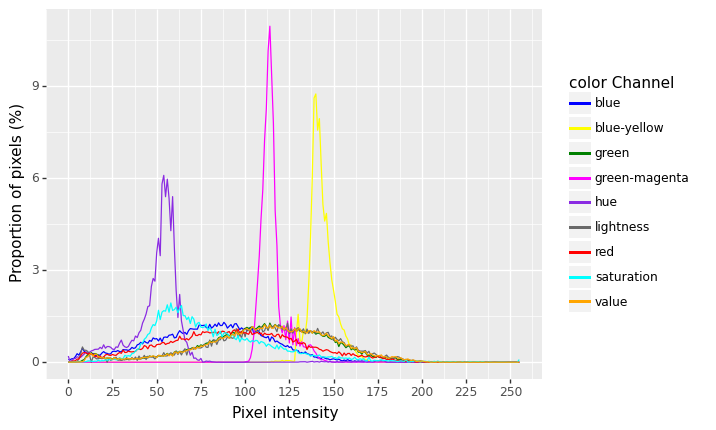

In [86]:
pcv.params.debug = None
color_histogram = pcv.analyze_color(
            rgb_img=img,
            mask=KEPT_MASK,
            colorspaces="all",
            label="default",
        )
print(color_histogram)

In [90]:
os.path.normpath("../tmp//")

'../tmp'